In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import gc
from scipy import interp
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import mean_absolute_error,  make_scorer
from scipy.special import jn
from sklearn.preprocessing import StandardScaler
from IPython.display import display, clear_output
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn import metrics
import lightgbm as lgb
import xgboost as xgb
## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
from scipy.special import jn
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
pd.options.display.max_columns = None
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn import model_selection
from scipy import interp
import matplotlib
import warnings
import random
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('SAE05.csv')
train_data = []
test_data = []
val_rate = 0.3
val_num = random.sample(range(len(data)), k=int(len(data) * val_rate))
for i in range(len(data)):
    if i in val_num:  # 如果该路径在采样的验证集样本中则存入验证集
        test_data.append(data.iloc[i,:])
    else:  # 否则存入训练集
        train_data.append(data.iloc[i,:])
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
## 输出数据的大小信息
print('train shape:',train_data.shape)
print('test shape:',test_data.shape)

train shape: (8722, 56)
test shape: (3738, 56)


In [3]:
x_train = train_data.drop(["SAE"], axis=1)
y_train = train_data["SAE"]
x_test = test_data.drop(["SAE"], axis=1)
y_test = test_data["SAE"]

In [4]:
log_reg = LogisticRegression(solver= "sag")
model = log_reg.fit(x_train,y_train)
predict_train= log_reg.predict(x_train)
print('Train AUC:',metrics.roc_auc_score(y_train, predict_train))

Train AUC: 0.6886753937965782


In [5]:
models = [LogisticRegression(solver= "sag"),
          SVC(kernel="rbf",probability=True),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          GradientBoostingClassifier(),
          MLPClassifier(solver='lbfgs', max_iter=100), 
          XGBClassifier(n_estimators = 100, objective='reg:squarederror'), 
          LGBMClassifier(n_estimators = 50)]

In [6]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=x_train, y=y_train, verbose=0, cv = 5, scoring=make_scorer(metrics.accuracy_score))
    result[model_name] = scores
    print(model_name + ' is finished')

LogisticRegression is finished
SVC is finished
DecisionTreeClassifier is finished
RandomForestClassifier is finished
GradientBoostingClassifier is finished
MLPClassifier is finished
XGBClassifier is finished
LGBMClassifier is finished


In [7]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LogisticRegression,SVC,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier,MLPClassifier,XGBClassifier,LGBMClassifier
cv1,0.692837,0.673926,0.725501,0.804011,0.801719,0.681948,0.794269,0.808596
cv2,0.691117,0.645845,0.708309,0.777650,0.780516,0.649857,0.772493,0.774785
cv3,0.673165,0.637615,0.715023,0.791858,0.801032,0.655963,0.784977,0.798165
cv4,0.677179,0.648509,0.710436,0.780390,0.787844,0.657683,0.774656,0.792431
cv5,0.693234,0.654817,0.721904,0.790711,0.797592,0.685780,0.787271,0.802752


# Train-AUC

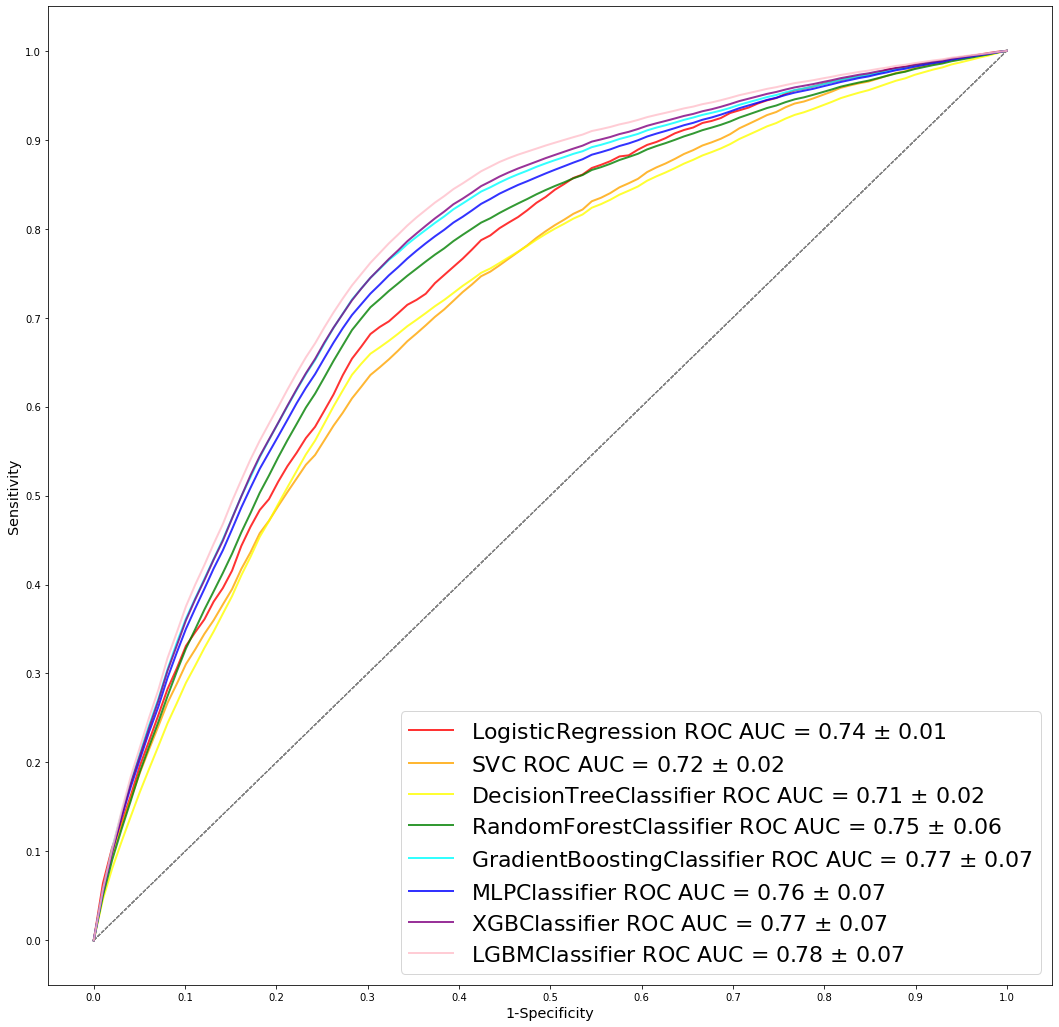

<Figure size 1296x1296 with 0 Axes>

In [8]:
matplotlib.rcParams['figure.figsize'] = (18.0, 18.0)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
result = dict()
cv = model_selection.ShuffleSplit(n_splits = 3, test_size = 0.3, random_state = 1)
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
c = 0
for model in models:
    model_name = str(model).split('(')[0]
    for train, test in cv.split(x_train, y_train):
        probas_ = model.fit(x_train.iloc[train], y_train.iloc[train]).predict_proba(x_train.iloc[test])
     # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
     #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
   
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray',alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=cs[c],label= model_name + r' ROC AUC = %0.2f $\pm$ %0.2f' % (mean_auc, std_auc),lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    c +=1

# 相关的设置被注释掉，可以恢复并查看画图效果。
#plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
#plt.xlim([-0, 1])
#plt.ylim([-0, 1])
    plt.xlabel('1-Specificity', fontsize = 'x-large')
    plt.ylabel('Sensitivity', fontsize = 'x-large')
#plt.title('Receiver operating characteristic example', fontsize = 'x-large')
    plt.legend(loc="lower right" ,prop={"size":22})
#plt.savefig('Train-ROC.jpg',dpi=300)

plt.show()
plt.savefig('train.pdf')


# Test-AUC

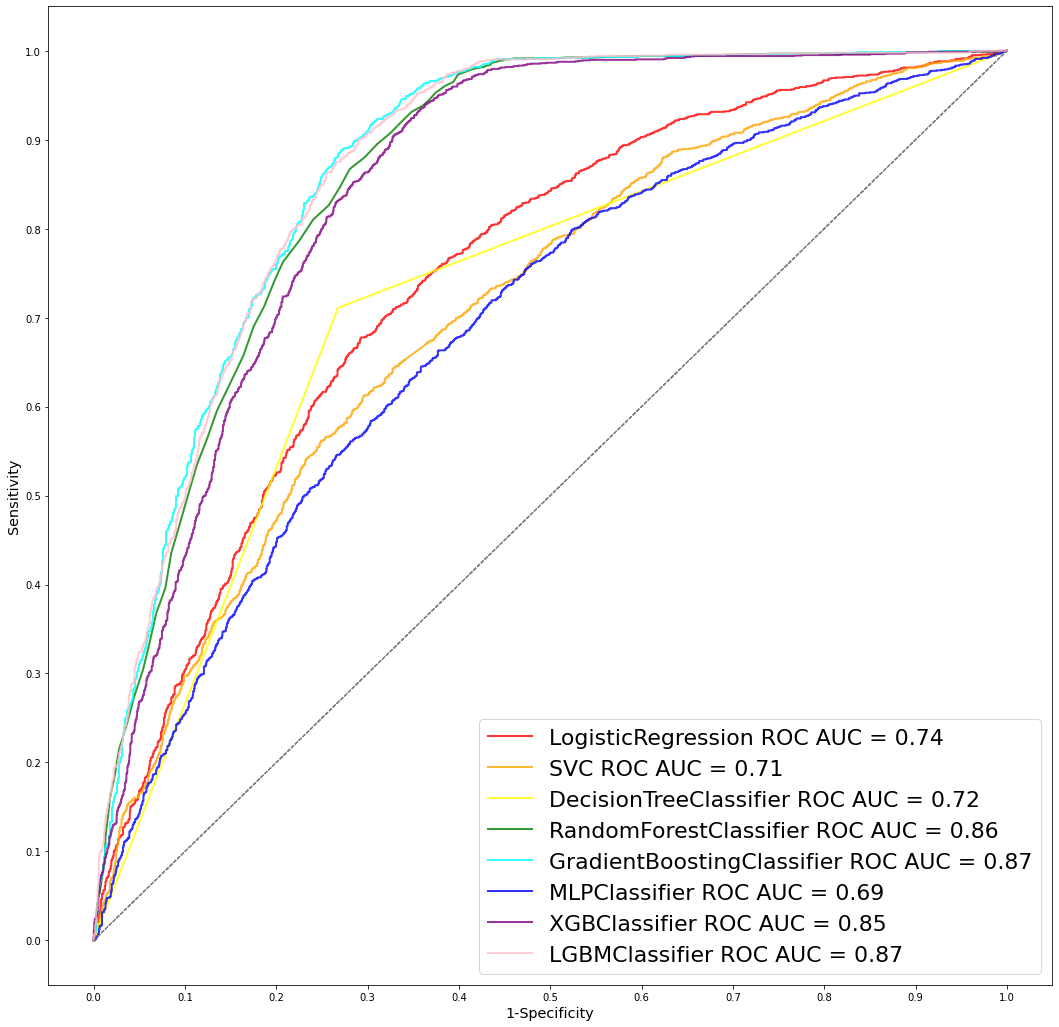

<Figure size 1296x1296 with 0 Axes>

In [9]:
#test
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
lw=2
i = 0
matplotlib.rcParams['figure.figsize'] = (18.0, 18.0)

plt.xticks(np.arange(0, 1.1, step=0.1))
plt.yticks(np.arange(0, 1.1, step=0.1))
result = dict()
cv = model_selection.ShuffleSplit(n_splits = 3, test_size = 0.3, random_state = 1)
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
c = 0
for model in models:
    model_name = str(model).split('(')[0]
    for train, test in cv.split(x_train, y_train):
        trainporbas_= model.fit(x_train.iloc[train], y_train.iloc[train]).predict_proba(x_train.iloc[test])
        probas_ = model.predict_proba(x_test)  #需要修改的是clf，即训练得到的model；以及测试集的X_test和y_test.
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        fpr=fpr
        tpr=tpr
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
            #plt.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    plt.plot(fpr, tpr, color=cs[c], alpha=.8, lw=lw, linestyle='-',label= model_name + r' ROC AUC = %0.2f' % roc_auc) 
            #plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--',alpha=.6)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', alpha=.8)

            #plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
            #plt.xlim([-0, 1])
        #plt.ylim([-0, 1])
    plt.xlabel('1-Specificity', fontsize = 'x-large')
    plt.ylabel('Sensitivity', fontsize = 'x-large')
        #plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right" ,prop={"size":22})
    c +=1
        #plt.savefig('Test-ROC.tiff',dpi=200)
plt.show()
